In [3]:
# for running this it should be on the root of the project
%load_ext autoreload
%autoreload 2
import torch
import torch.optim as optim
import argparse
import pandas as pd
import os
from tqdm import tqdm
import sys
sys.path.insert(0, '/Users/maruanottoni/home/master/research/graph-corr-embedd/src')

from models.SAE import StackedSparseAutoencoder
from utils.conn_data import save_pickle
from utils.parsers import str_2_bool
from data.Simulation1Loader import Simulation1Loader
from simulation.GraphSim import GraphSim
from utils.activation_functions import sigmoid

from models.Spectrum import Spectrum

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.stats import spearmanr, norm
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.stats import spearmanr
from tqdm import tqdm

import numpy as np
import networkx as nx
from scipy.stats import spearmanr
from tqdm import tqdm



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Defining params

In [4]:
simulation_name = 'simulation2_test_spectrum'
source_path = f'/Users/maruanottoni/home/master/research/graph-corr-embedd/data/simulations/{simulation_name}'

In [10]:
#all_graphs = {}
simulation_name = "Graph Correlation Analysis"

# Example usage
n_graphs = [10, 20]  # Example list of numbers of graphs 20,40,60,80,100
n_simulations = 60 # should be 1000
n_nodes = 50 # 50
s_initial = 0.8 # testes with 0.5 and 0
graph_classes = [
    "erdos_renyi",
    "random_geometric",
    #"random_regular",
    "barabasi_albert",
    "watts_strogatz",
]

In [11]:
# Check if path exists
output_path = f"{source_path}/data/inputs/{simulation_name}"
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Start simluation

In [12]:
#TODO: add 2 keys one for the first graph family and other ofr the second family of graph

def run_simulation(n_graphs, n_simulations, n_nodes, s_initial, graph_classes):
    embed_dict = {graph_name: {n_graph: [] for n_graph in n_graphs} for graph_name in graph_classes}
    params_dict = {graph_name: {n_graph: [] for n_graph in n_graphs} for graph_name in graph_classes}
    
    for n_graph in n_graphs:
        for graph_name in tqdm(graph_classes, desc=f"Simulating {n_graph} graphs"):
            gs = GraphSim(graph_name=graph_name)
            for _ in range(n_simulations):
                embeddings1 = []
                embeddings2 = []
                params = []

                for _ in range(n_graph):
                    # Generate parameters and normalize
                    gs.update_seed()
                    p = gs.get_p_from_bivariate_gaussian(s=s_initial)
                    p = sigmoid(np.abs(p))  # normalize

                    # Simulate graphs based on the graph type
                    if graph_name == "erdos_renyi":
                        graph1 = gs.simulate_erdos(n=n_nodes, prob=p[0, 0])
                        graph2 = gs.simulate_erdos(n=n_nodes, prob=p[0, 1])
                    elif graph_name == "random_geometric":
                        graph1 = gs.simulate_geometric(n=n_nodes, radius=p[0, 0])
                        graph2 = gs.simulate_geometric(n=n_nodes, radius=p[0, 1])
                    elif graph_name == "barabasi_albert":
                        graph1 = gs.simulate_barabasi_albert(n=n_nodes, m=int(10*p[0, 0]))
                        graph2 = gs.simulate_barabasi_albert(n=n_nodes, m=int(10*p[0, 1]))
                    elif graph_name == "watts_strogatz":
                        graph1 = gs.simulate_watts_strogatz(n=n_nodes, k=3, p=p[0, 0])
                        graph2 = gs.simulate_watts_strogatz(n=n_nodes, k=3, p=p[0, 1])

                    ##############
                    # Fujita method
                    # TODO: Try embedders
                    largest_eigenvalue1 = Spectrum().forward(nx.adjacency_matrix(graph1).A)
                    largest_eigenvalue2 = Spectrum().forward(nx.adjacency_matrix(graph2).A)
                    ############3##

                    embeddings1.append(largest_eigenvalue1)
                    embeddings2.append(largest_eigenvalue2)
                    params.append(p[0])

                embed_dict[graph_name][n_graph].append((embeddings1, embeddings2))
                params_dict[graph_name][n_graph].append(params)

    return embed_dict, params_dict

In [13]:
# Run the simulation
#all_graphs = run_simulation(n_graphs, n_simulations, n_nodes, s_initial, graph_classes)
eigen, params = run_simulation(n_graphs, n_simulations, n_nodes, s_initial, graph_classes)

Simulating 20 graphs: 100%|██████████| 4/4 [00:25<00:00,  6.26s/it]


In [15]:
#TODO: Fix
def get_spearm_pvalues_baseline(params, n_graph, n_simulations):
    pvalues = []
    for i in range(n_simulations):
        families = list(params.keys())
        print(params[families[0]][n_graph][i])
        first_run, second_run = params[families[0]][n_graph][i]
        pvalues.append(spearmanr(first_run[0], second_run[0]).pvalue)
    return pvalues

#pval = get_spearm_pvalues_baseline(params=params, n_graph=n_graphs[0], n_simulations=n_simulations)
#pval

In [16]:
def get_spearm_pvalues_same_family(eigenvalues_dict, family, n_graphs, n_simulations):
    pvalues = []
    for i in range(n_simulations):
        first_run, second_run = eigenvalues_dict[family][n_graphs][i]
        pvalues.append(spearmanr(first_run, second_run).pvalue)
    return pvalues

#pval = get_spearm_pvalues_same_family(eigen, 'erdos_renyi', n_graphs=n_graphs[0], n_simulations=n_simulations)

In [17]:
def get_spearman_pvalues(eigenvalues_dict, first_family_name, second_family_name, n_simulations, n_graphs):
    pvalues = []
    for i in range(n_simulations):
        first_family = eigenvalues_dict[first_family_name][n_graphs][i]
        second_family = eigenvalues_dict[second_family_name][n_graphs][i]
        pvalues.append(spearmanr(first_family[0], second_family[0]).pvalue) # 0 because i run 2 times for each graph
    return pvalues

pval = get_spearman_pvalues(eigen, n_simulations=n_simulations, n_graphs=n_graphs[0],
                            first_family_name='erdos_renyi', second_family_name='random_geometric')

# Analyse the result

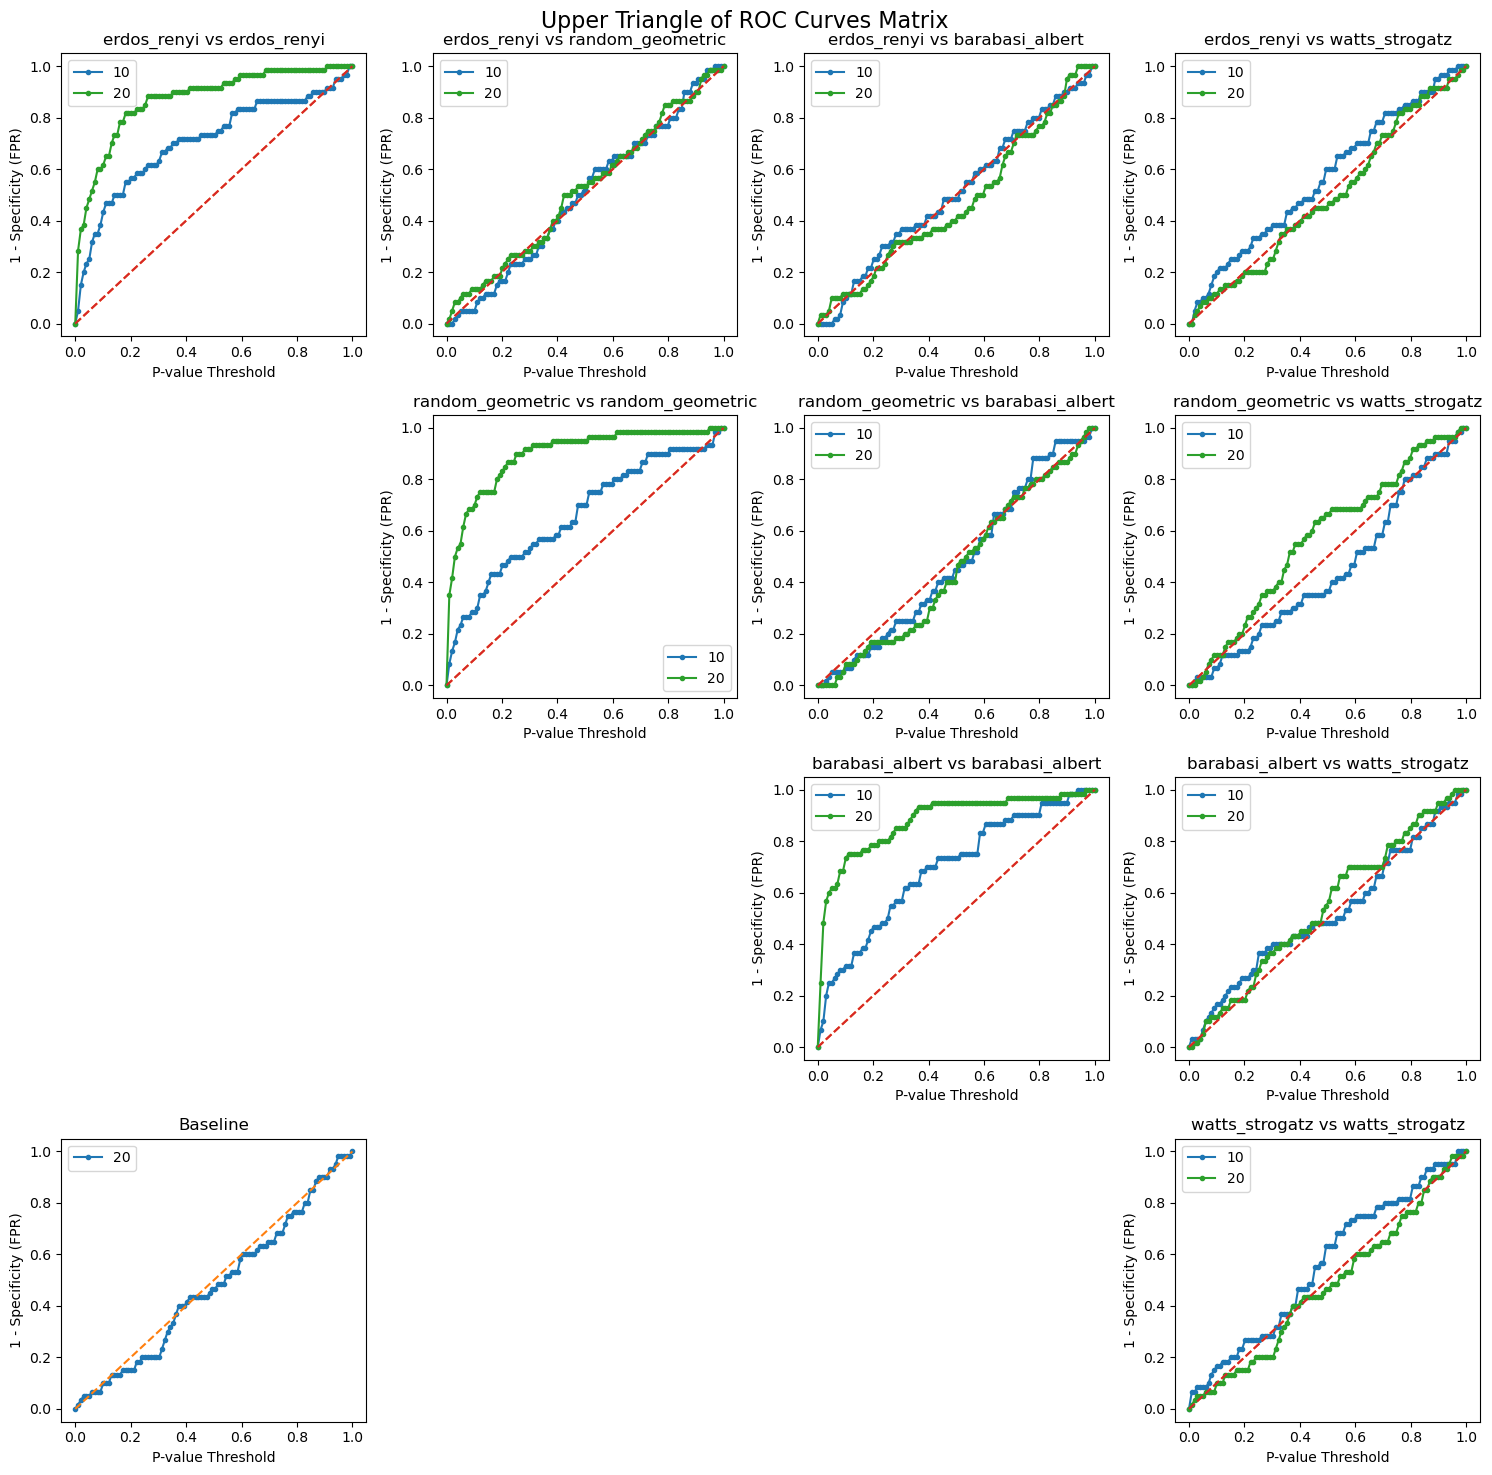

In [18]:
graph_types = graph_classes

# Function to calculate FPR
def calculate_rates(p_values, threshold):
    fp, tn = 0, 0
    for p_value in p_values:
        if p_value > threshold:
            fp += 1
        else:
            tn += 1
    return tn / (fp + tn) if (fp + tn) > 0 else 0

# Plotting the matrix of ROC curves
fig, axs = plt.subplots(len(graph_types), len(graph_types), figsize=(15, 15))

# Iterate over each graph type pair and plot the ROC curve
for n_graph in n_graphs:
    for i, gt1 in enumerate(graph_types):
        for j, gt2 in enumerate(graph_types):
            if j > i:  # This condition ensures we only fill the upper triangle
                # Calculate FPRs for each threshold
                thresholds = np.linspace(0, 1, 100)
                pval = get_spearman_pvalues(eigen, n_simulations=n_simulations, n_graphs=n_graph,
                                            first_family_name=gt1, second_family_name=gt2)
                fprs = [calculate_rates(pval, th) for th in thresholds]
                
                axs[i, j].plot(thresholds, fprs, marker='.', label=f'{n_graph}' )
                axs[i, j].plot([0, 1], [0, 1], linestyle='--')
                axs[i, j].set_xlabel('P-value Threshold')
                axs[i, j].set_ylabel('1 - Specificity (FPR)')
                axs[i, j].set_title(f'{gt1} vs {gt2}')
                axs[i, j].legend()
            elif j == i:
                # Calculate FPRs for each threshold
                thresholds = np.linspace(0, 1, 100)
                pval = get_spearm_pvalues_same_family(eigen, gt1, n_graphs=n_graph, n_simulations=n_simulations)
                fprs = [calculate_rates(pval, th) for th in thresholds]
                
                axs[i, j].plot(thresholds, fprs, marker='.', label=f'{n_graph}')
                axs[i, j].plot([0, 1], [0, 1], linestyle='--')
                axs[i, j].set_xlabel('P-value Threshold')
                axs[i, j].set_ylabel('1 - Specificity (FPR)')
                axs[i, j].set_title(f'{gt1} vs {gt2}')
                axs[i, j].legend()
            else:
                # Turn off the axis for lower triangle and diagonal plots
                axs[i, j].axis('off')



i = len(graph_types) - 1
j = 0
axs[i, j].axis('on')
axs[i, j].plot(thresholds, fprs, marker='.', label=f'{n_graph}')
axs[i, j].plot([0, 1], [0, 1], linestyle='--')
axs[i, j].set_xlabel('P-value Threshold')
axs[i, j].set_ylabel('1 - Specificity (FPR)')
axs[i, j].set_title(f'Baseline')
axs[i, j].legend()

# Adjust layout and display the plot
plt.suptitle('Upper Triangle of ROC Curves Matrix', fontsize=16)
plt.tight_layout()
plt.legend()
plt.show()


In [19]:
for i, gt1 in enumerate(graph_types):
    for j, gt2 in enumerate(graph_types):
        print(gt1)

erdos_renyi
erdos_renyi
erdos_renyi
erdos_renyi
random_geometric
random_geometric
random_geometric
random_geometric
barabasi_albert
barabasi_albert
barabasi_albert
barabasi_albert
watts_strogatz
watts_strogatz
watts_strogatz
watts_strogatz
